In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/unsw-nb15-processed-dataset-v2/processed_unsw_nb15.csv
/kaggle/input/unsw-nb15-processed-dataset-v2/NUSW-NB15_features.csv


<h1 style="padding: 10px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:180%"><b> Imports </b></h1>

In [4]:
import os
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf

import lightgbm as lgb
from catboost import CatBoostClassifier

import keras_tuner as kt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report, 
    accuracy_score, 
    confusion_matrix, 
    ConfusionMatrixDisplay, 
    roc_auc_score, 
    precision_score, 
    recall_score, 
    f1_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, 
    Conv1D, 
    MaxPooling1D, 
    Flatten, 
    LSTM, 
    Bidirectional, 
    Dropout, 
    BatchNormalization, 
    TimeDistributed, 
    RepeatVector, 
    Conv2D, 
    MaxPooling2D, 
    UpSampling2D, 
    Reshape
)
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings('ignore')

<h1 style="padding: 10px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:180%"><b> Understanding the Structure of the Datasets </b></h1>

In [3]:
# Load the features file
NB15_features = pd.read_csv('/kaggle/input/unsw-nb15-processed-dataset-v2/NUSW-NB15_features.csv')

# Dataset structure
NB15_features.info()

# Display the dataframe
display(NB15_features)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Name         24 non-null     object
 1   Description  24 non-null     object
dtypes: object(2)
memory usage: 512.0+ bytes


,Name,Description
0,dur,Flow duration
1,sbytes,Source-to-destination bytes
2,dbytes,Destination-to-source bytes
3,Sload,Source-to-destination load
4,swin,Source TCP window size
5,smeansz,Source packet size mean
6,Sjit,Source jitter (msec)
7,Stime,Source packet inter-arrival time
8,tcprtt,TCP round trip time
9,ct_srv_src,Connection count per service from source


## 2. Output Classes

The **attack_cat** column in the dataset signifies the different types of network traffic, with each unique numerical value representing a distinct class.ass. These categories encompass a range of attack types as well as normal traffic, allowing for comprehensive analysis of network behavior. 

- **0:** analysis  
- **1:** backdoor  
- **2:** backdoors  
- **3:** dos (Denial of Service)  
- **4:** exploits  
- **5:** fuzzers  
- **6:** generic  
- **7:** normal  
- **8:** reconnaissance  
- **9:** shellcode  
- **10:** worms 


## 3. Inspect the dataset

In [5]:
# Load the processed dataset
NB15_data = pd.read_csv('/kaggle/input/unsw-nb15-processed-dataset-v2/processed_unsw_nb15.csv')

# Inspect the dataset
print("Dataset overview:")
display(NB15_data.head())
display(NB15_data.info())

Dataset overview:


,dur,sbytes,dbytes,Sload,swin,smeansz,Sjit,Stime,tcprtt,ct_srv_src,...,duration,byte_ratio,jit_ratio,inter_pkt_ratio,tcp_setup_ratio,total_load,byte_pkt_interaction_dst,load_jit_interaction_dst,tcp_seq_diff,attack_cat
0,-10.871072,5.298317,-11.512925,13.200695,5.541264,4.605170,-11.512925,9.779737,-6.313324,1.791761,...,5.658509e-05,-0.503981,1.095121,0.447965,0.470330,1.687770,132.547453,132.547453,0.000000,0
1,-3.633407,6.752270,7.241366,8.328193,-10.819778,4.454347,3.447042,8.976768,-6.754176,0.000010,...,-1.263184e-04,0.819314,0.875988,-0.436142,0.473253,17.145182,16.673869,25.878166,0.551796,0
2,-10.770988,5.298317,-11.512925,13.200695,5.541264,4.605170,-11.512925,14.661989,-6.313324,2.639058,...,4.289225e-07,-0.503981,1.095121,0.428896,0.470330,1.687770,132.547453,132.547453,0.000000,0
3,-10.819778,5.298317,-11.512925,13.200695,5.541264,4.605170,-11.512925,14.661920,-6.313324,2.397896,...,4.289521e-07,-0.503981,1.095121,0.437953,0.470330,1.687770,132.547453,132.547453,0.000000,0
4,-10.925139,5.298317,-11.512925,13.200695,5.541264,4.605170,-11.512925,10.367190,-6.313324,1.386297,...,3.144704e-05,-0.503981,1.095121,0.459155,0.470330,1.687770,132.547453,132.547453,0.000000,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165000 entries, 0 to 164999
Data columns (total 24 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   dur                       165000 non-null  float64
 1   sbytes                    165000 non-null  float64
 2   dbytes                    165000 non-null  float64
 3   Sload                     165000 non-null  float64
 4   swin                      165000 non-null  float64
 5   smeansz                   165000 non-null  float64
 6   Sjit                      165000 non-null  float64
 7   Stime                     165000 non-null  float64
 8   tcprtt                    165000 non-null  float64
 9   ct_srv_src                165000 non-null  float64
 10  ct_srv_dst                165000 non-null  float64
 11  ct_dst_ltm                165000 non-null  float64
 12  ct_src_ ltm               165000 non-null  float64
 13  ct_dst_src_ltm            165000 non-null  f

None

<h1 style="padding: 10px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:180%"><b> Splitting the dataset into train and test </b></h1>

In [6]:
# Load the processed dataset
NB15_data = pd.read_csv('/kaggle/input/unsw-nb15-processed-dataset-v2/processed_unsw_nb15.csv')

# Separate features and target variable
X = NB15_data.drop(columns=['attack_cat'])  # Features 
y = NB15_data['attack_cat']  # Target column

# Convert target variable to categorical
y_categorical = to_categorical(y)

# Split the dataset into train and test sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42)

# Displaying the shapes of the resulting datasets
print("\nShape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)


Shape of X_train: (132000, 23)
Shape of X_test: (33000, 23)
Shape of y_train: (132000, 11)
Shape of y_test: (33000, 11)


<h1 style="padding: 10px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:180%"><b> Training and Evaluating Supervised ML Models </b></h1>

## 1. K-Nearest Neighbors (KNN)

Accuracy: 0.7731515151515151
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.66      0.45      2895
           1       0.63      0.52      0.57      2924
           2       0.88      0.89      0.88      3064
           3       0.64      0.56      0.60      3000
           4       0.80      0.57      0.66      3032
           5       0.91      0.78      0.84      2942
           6       0.96      0.81      0.88      3035
           7       0.99      0.97      0.98      3040
           8       0.87      0.75      0.81      3060
           9       0.90      0.97      0.94      3017
          10       0.96      1.00      0.98      2991

    accuracy                           0.77     33000
   macro avg       0.81      0.77      0.78     33000
weighted avg       0.81      0.77      0.78     33000



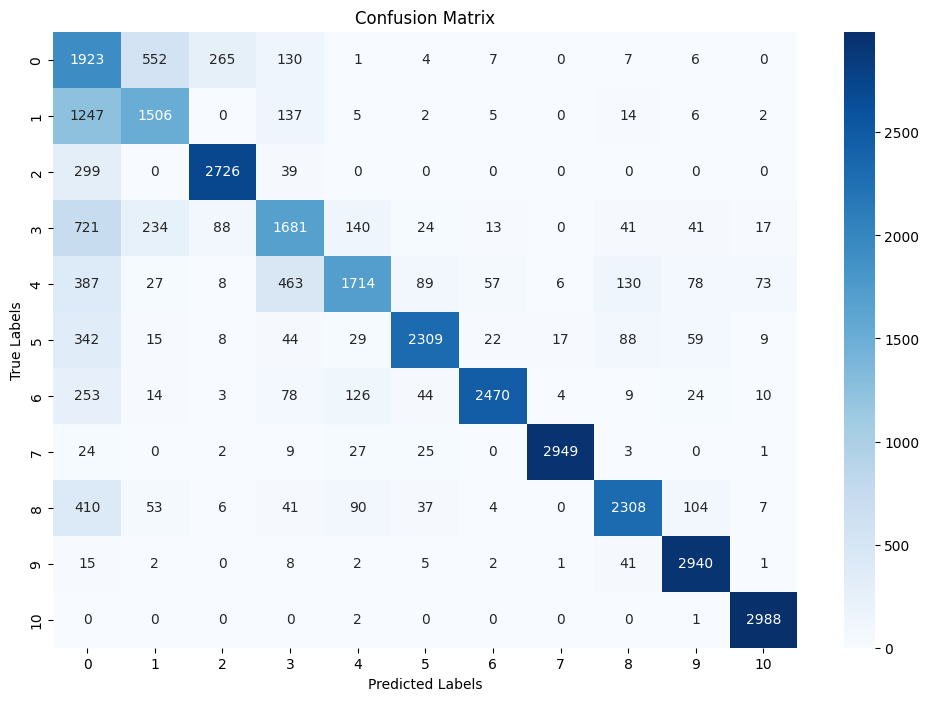

In [13]:
# Initialize the KNN model with specified hyperparameters
knn_model = KNeighborsClassifier(
    n_neighbors=3,      # Number of neighbors to use (default is 5)
    weights='distance', # Weight function used in prediction; options: distance - 'uniform' (default)
    metric='manhattan' # Distance metric to use; options: 'euclidean' (default) - chebyshev
)

# Fit the model to the training data
knn_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = knn_model.predict(X_test)

# Since y_pred contains probabilities, take the index of the max probability
y_pred_classes = y_pred.argmax(axis=1)

# Convert y_test back to class labels from categorical
y_test_classes = y_test.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 2. Decision Tree

Accuracy: 0.7622424242424243
Classification Report:
               precision    recall  f1-score   support

           0       0.34      0.64      0.44      2895
           1       0.62      0.50      0.55      2924
           2       0.88      0.87      0.87      3064
           3       0.56      0.44      0.50      3000
           4       0.71      0.61      0.66      3032
           5       0.91      0.82      0.86      2942
           6       0.94      0.85      0.90      3035
           7       0.99      0.98      0.98      3040
           8       0.91      0.78      0.84      3060
           9       0.89      0.89      0.89      3017
          10       0.97      0.98      0.98      2991

    accuracy                           0.76     33000
   macro avg       0.79      0.76      0.77     33000
weighted avg       0.79      0.76      0.77     33000



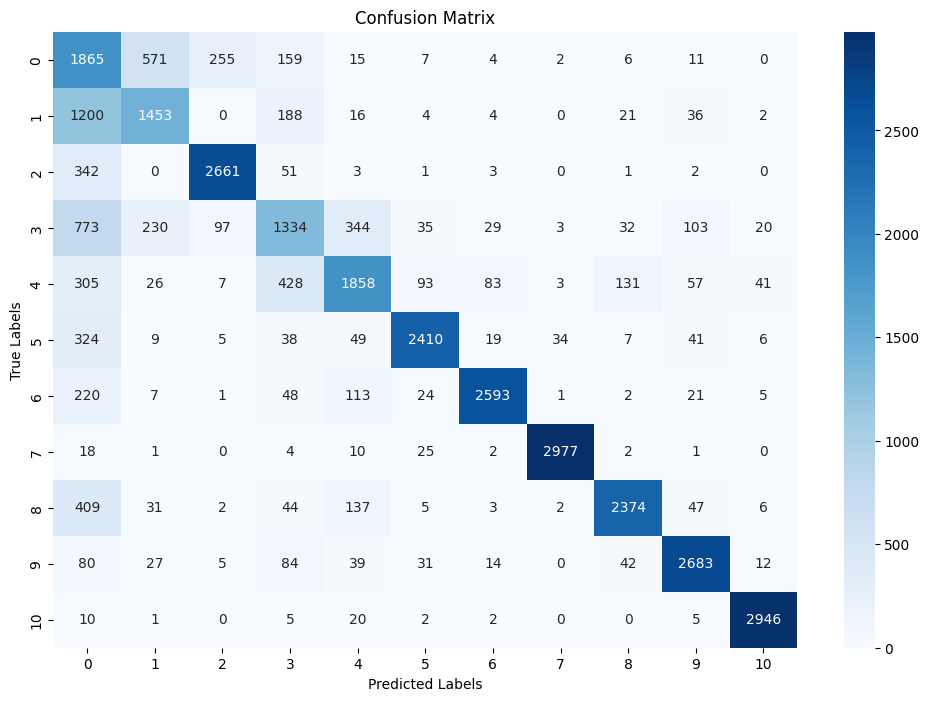

In [32]:
# Initialize the Decision Tree model with specified hyperparameters
dt_model = DecisionTreeClassifier( 
    criterion='entropy',   # 'gini' (default) or 'entropy' for information gain
    splitter='best',       # 'best' (default) or 'random' to choose the best split or a random one
    max_depth=None,        # Integer (e.g., 10) to limit the depth or None for no limit (default)
    min_samples_split=5,   # Integer (e.g., 5) to specify minimum samples required to split an internal node (default is 2)
    min_samples_leaf=1,    # Integer (e.g., 2) to specify minimum samples required to be at a leaf node (default is 1)
    random_state=42        # Integer (e.g., 0) for reproducible results or None for random seed
)

# Fit the model to the training data
dt_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = dt_model.predict(X_test)

# Since y_pred contains probabilities, take the index of the max probability
y_pred_classes = y_pred.argmax(axis=1)

# Convert y_test back to class labels from categorical
y_test_classes = y_test.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 3. Random Forest

Accuracy: 0.7800303030303031
Classification Report:
               precision    recall  f1-score   support

           0       0.30      0.77      0.44      2895
           1       0.70      0.39      0.50      2924
           2       0.86      0.98      0.91      3064
           3       0.85      0.43      0.57      3000
           4       0.85      0.62      0.72      3032
           5       0.95      0.84      0.89      2942
           6       0.99      0.83      0.90      3035
           7       1.00      0.98      0.99      3040
           8       0.95      0.78      0.85      3060
           9       0.94      0.93      0.93      3017
          10       0.98      1.00      0.99      2991

    accuracy                           0.78     33000
   macro avg       0.85      0.78      0.79     33000
weighted avg       0.85      0.78      0.79     33000



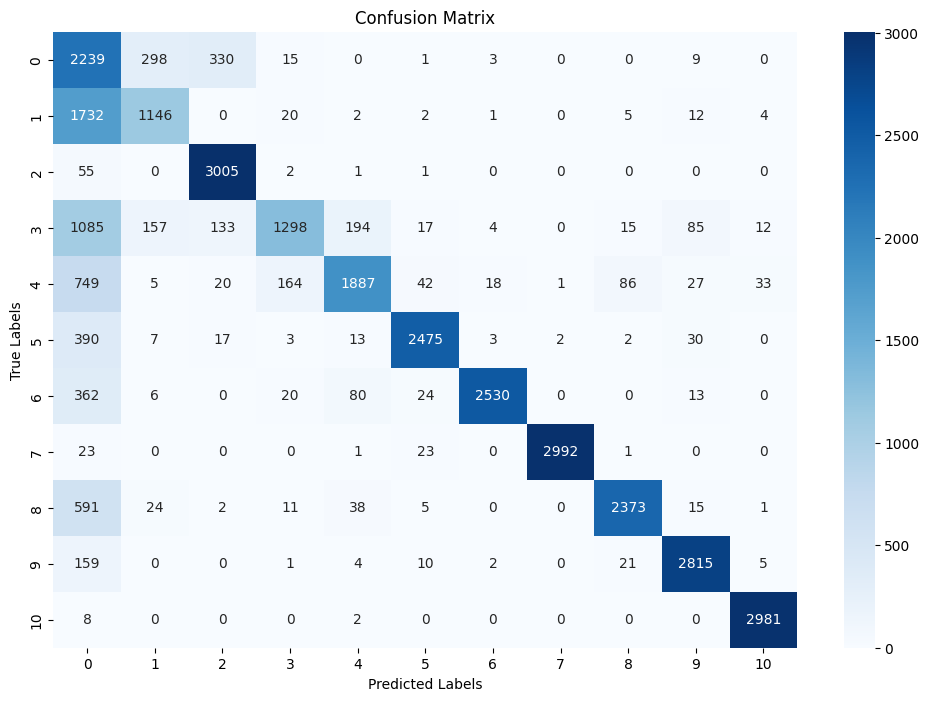

In [29]:
# Initialize the Random Forest model with specified hyperparameters
rf_model = RandomForestClassifier( 
    n_estimators=120,          
    max_depth=25,          
    min_samples_split=2,      
    random_state=42,  # Set a fixed random state for reproducibility
    class_weight='balanced'  # Balance the class weights
)

# Fit the model to the training data
rf_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf_model.predict(X_test)

# Since y_pred contains probabilities, take the index of the max probability
y_pred_classes = y_pred.argmax(axis=1)

# Convert y_test back to class labels from categorical
y_test_classes = y_test.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 4. XGBoost Model

Accuracy: 0.7921818181818182
Classification Report:
               precision    recall  f1-score   support

           0       0.31      0.72      0.44      2895
           1       0.66      0.48      0.56      2924
           2       0.87      0.96      0.91      3064
           3       0.88      0.42      0.57      3000
           4       0.84      0.68      0.75      3032
           5       0.96      0.87      0.91      2942
           6       0.99      0.85      0.91      3035
           7       1.00      0.98      0.99      3040
           8       0.95      0.78      0.86      3060
           9       0.94      0.95      0.95      3017
          10       0.99      1.00      0.99      2991

    accuracy                           0.79     33000
   macro avg       0.85      0.79      0.80     33000
weighted avg       0.86      0.79      0.81     33000



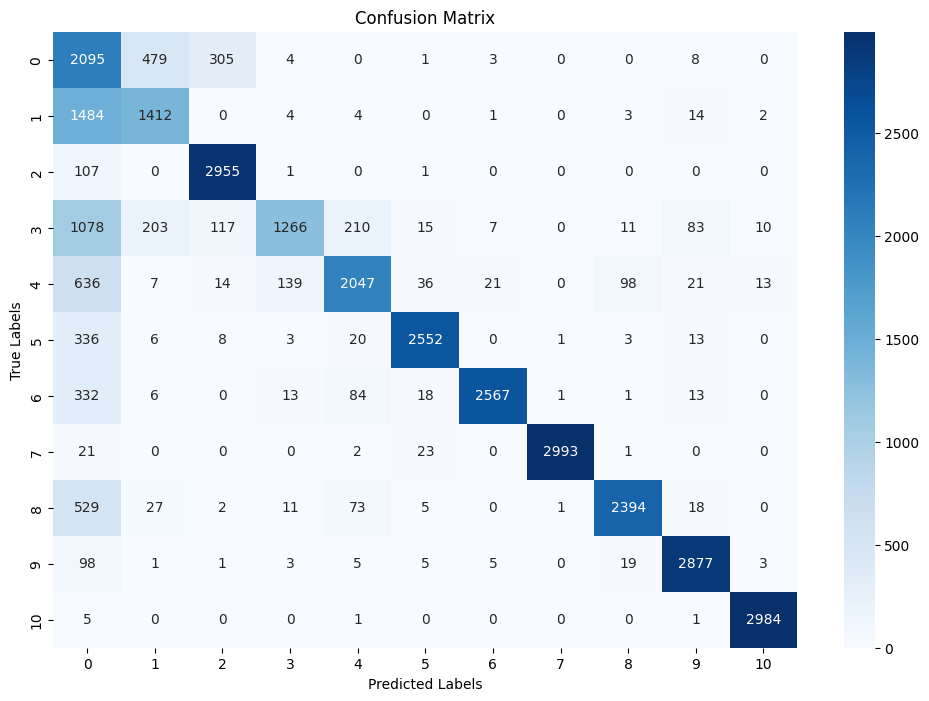

In [16]:
# Initialize the XGBoost model with specified hyperparameters
xgb_model = XGBClassifier( 
    n_estimators=350,           # Number of trees
    max_depth=9,                # Maximum depth of each tree
    learning_rate=0.1,          # Step size shrinkage
    subsample=0.9,              # Subsample ratio of the training instances
    colsample_bytree=0.8,       # Subsample ratio of columns when constructing each tree
    use_label_encoder=False,     # Disable label encoder
    eval_metric='mlogloss'      # Evaluation metric for validation
)

# Fit the model to the training data
xgb_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = xgb_model.predict(X_test)

# Since y_pred contains probabilities, take the index of the max probability
y_pred_classes = y_pred.argmax(axis=1)

# Convert y_test back to class labels from categorical
y_test_classes = y_test.argmax(axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_test_classes, y_pred_classes)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test_classes, y_pred_classes)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 5. LightGBM 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5645
[LightGBM] [Info] Number of data points in the train set: 132000, number of used features: 23
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
[LightGBM] [Info] Start training from score -2.397895
Accuracy: 0.8203333333333334
Classif

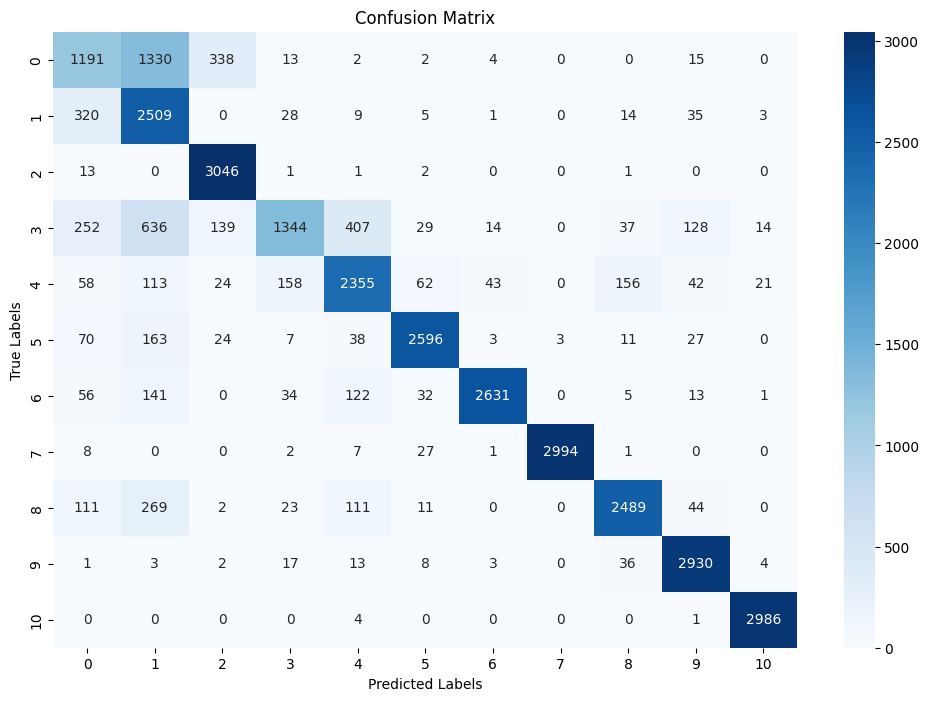

In [7]:
# Initialize the LightGBM model with specified hyperparameters
lgb_model = lgb.LGBMClassifier(
    n_estimators=500,           # Number of boosting rounds
    learning_rate=0.05,         # Step size for each boosting round
    max_depth=-1,               # Maximum depth of each tree (default is unlimited)
    num_leaves=31,              # Maximum number of leaves in one tree
    colsample_bytree=0.8,       # Fraction of features to consider at each split
    subsample=0.8,              # Fraction of samples to use for each tree
    class_weight='balanced',     # Automatically adjust weights inversely proportional to class frequencies
    random_state=42              # Fixed random state for reproducibility
)

# Fit the model to the training data
lgb_model.fit(X_train, y_train.argmax(axis=1))  # Use argmax to convert categorical back to labels

# Make predictions on the test data
y_pred = lgb_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test.argmax(axis=1), y_pred)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## 6. CatBoost

Accuracy: 0.8026060606060607
Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.36      0.47      2895
           1       0.47      0.91      0.62      2924
           2       0.85      0.99      0.91      3064
           3       0.79      0.37      0.51      3000
           4       0.73      0.74      0.73      3032
           5       0.91      0.86      0.88      2942
           6       0.96      0.84      0.90      3035
           7       0.99      0.99      0.99      3040
           8       0.89      0.82      0.85      3060
           9       0.85      0.93      0.89      3017
          10       0.94      1.00      0.97      2991

    accuracy                           0.80     33000
   macro avg       0.82      0.80      0.79     33000
weighted avg       0.83      0.80      0.80     33000



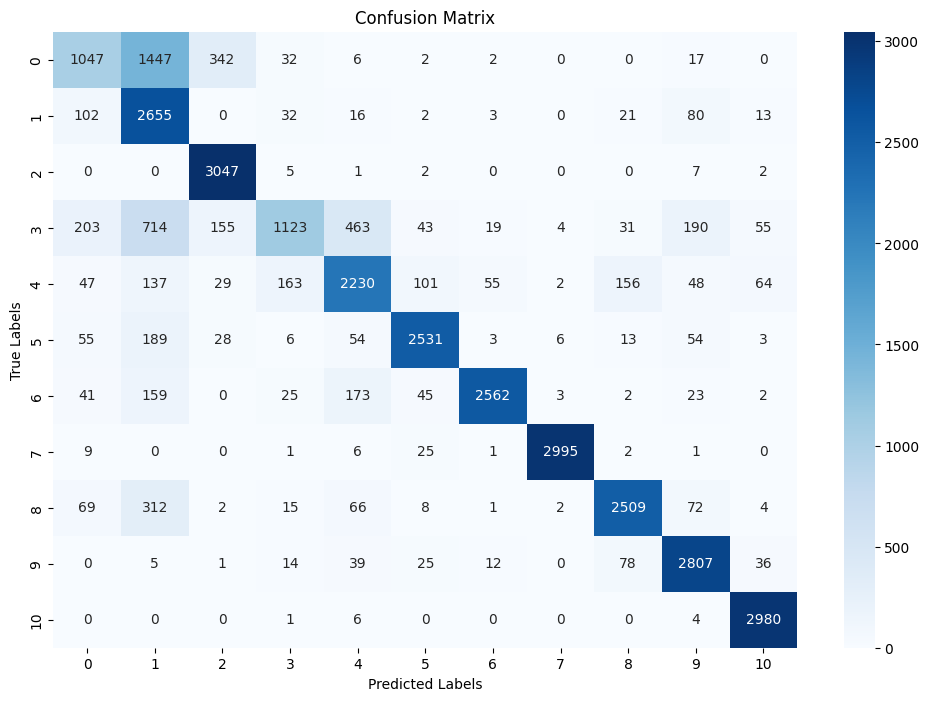

In [36]:
# Initialize the CatBoost model with specified hyperparameters
catboost_model = CatBoostClassifier(
    iterations=600,          # Number of boosting iterations
    learning_rate=0.09,       # Step size for each iteration
    depth=6,                 # Depth of the trees
    l2_leaf_reg=3,           # L2 regularization coefficient
    verbose=0,               # Suppress verbose output
    random_seed=42           # Fixed random state for reproducibility
)

# Fit the model to the training data
catboost_model.fit(X_train, y_train.argmax(axis=1))  # Use argmax to convert categorical back to labels

# Make predictions on the test data
y_pred = catboost_model.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test.argmax(axis=1), y_pred)
print("Accuracy:", accuracy)

# Generate classification report
class_report = classification_report(y_test.argmax(axis=1), y_pred)
print("Classification Report:\n", class_report)

# Generate and display confusion matrix
conf_matrix = confusion_matrix(y_test.argmax(axis=1), y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

<h1 style="padding: 10px;color:white; display:fill;background-color:#555555; border-radius:5px; font-size:180%"><b> Training and Evaluating DL Models </b></h1>

## 0. Keras Tuner for Hyperparameter Tuning
To enhance deep learning model training by incorporating automated hyperparameter tuning, we can use libraries such as Keras Tuner or Optuna. These libraries allow you to define a hyperparameter search space and automate the tuning process to find the best hyperparameters for your model.

## 1. Fully Connected Neural Network (FCNN)

Trial 60 Complete [00h 01m 15s]
val_accuracy: 0.5005303025245667

Best val_accuracy So Far: 0.6893181800842285
Total elapsed time: 01h 19m 15s
Epoch 1/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - accuracy: 0.6401 - loss: 1.0152 - val_accuracy: 0.6866 - val_loss: 0.8903
Epoch 2/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6444 - loss: 1.0008 - val_accuracy: 0.6774 - val_loss: 0.8967
Epoch 3/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6440 - loss: 1.0055 - val_accuracy: 0.6783 - val_loss: 0.8822
Epoch 4/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6467 - loss: 0.9967 - val_accuracy: 0.6919 - val_loss: 0.8730
Epoch 5/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6500 - loss: 0.9846 - val_accuracy: 0.6899 - val_loss: 0.8608
Epoch 6/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6525 - loss: 0.9802 - val_accuracy: 0.6777 - val_loss: 0.8750
Epoch 7/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 0.6531 - l

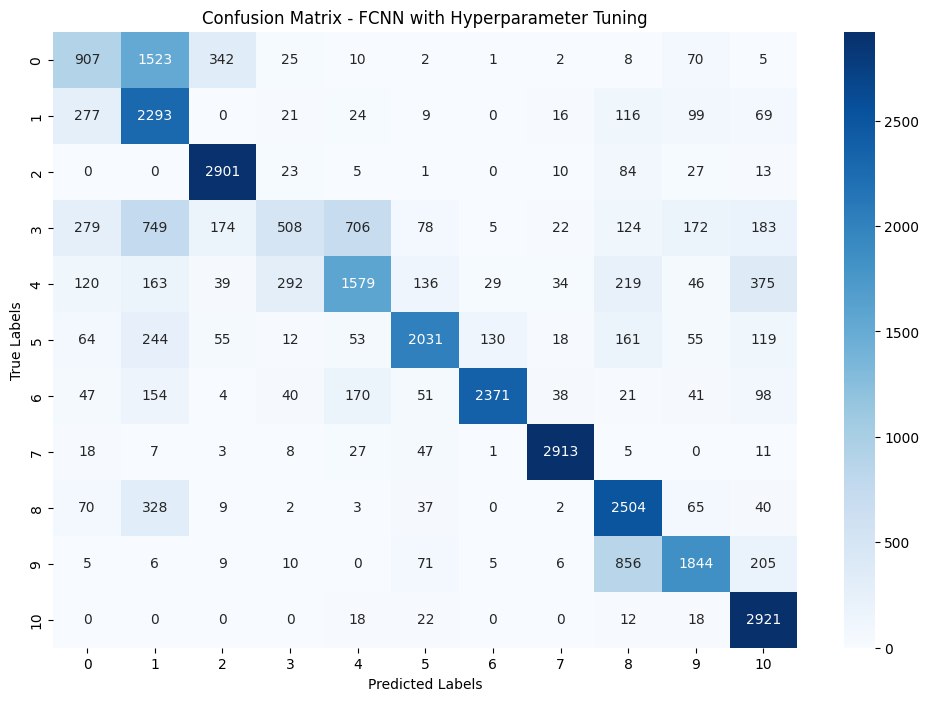

In [6]:
# Define a function to build the FCNN model with more hyperparameters
def build_fcnn_model(hp):
    model = Sequential()
    
    # First Hidden Layer
    model.add(Dense(units=hp.Int('units_1', min_value=64, max_value=256, step=64), 
                    activation=hp.Choice('activation_1', ['relu', 'tanh'], default='relu'), 
                    input_shape=(X_train.shape[1],)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # Second Hidden Layer
    model.add(Dense(units=hp.Int('units_2', min_value=64, max_value=256, step=64), 
                    activation=hp.Choice('activation_2', ['relu', 'tanh'], default='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    # Third Hidden Layer
    model.add(Dense(units=hp.Int('units_3', min_value=64, max_value=256, step=64), 
                    activation=hp.Choice('activation_3', ['relu', 'tanh'], default='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', 0.2, 0.5, step=0.1)))

    # Fourth Hidden Layer
    model.add(Dense(units=hp.Int('units_4', min_value=64, max_value=256, step=64), 
                    activation=hp.Choice('activation_4', ['relu', 'tanh'], default='relu')))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_4', 0.2, 0.5, step=0.1)))

    # Output Layer
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    # Tuning learning rate and optimizer
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd'], default='adam'),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Initialize the Tuner for FCNN using RandomSearch
tuner_fcnn = kt.RandomSearch(
    build_fcnn_model,
    objective='val_accuracy',
    max_trials=60,
    executions_per_trial=1,
    directory='Tuner',
    project_name='fcnn_random_search'
)

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)

# Search for the best hyperparameters with 15 epochs
tuner_fcnn.search(X_train, y_train, 
                  epochs=10,
                  validation_split=0.2, 
                  callbacks=[early_stopping])

# Get the best FCNN model
best_fcnn_model = tuner_fcnn.get_best_models(num_models=1)[0]

# Train the best model with 80 epochs
best_fcnn_model.fit(X_train, y_train, 
                    epochs=80, 
                    validation_split=0.2, 
                    callbacks=[early_stopping])

# Evaluate the best FCNN model
y_pred_fcnn = best_fcnn_model.predict(X_test)
y_pred_classes_fcnn = y_pred_fcnn.argmax(axis=1)

# Print Accuracy and Classification Report for FCNN
print("FCNN Best Model Accuracy:", accuracy_score(y_test.argmax(axis=1), y_pred_classes_fcnn))
print("FCNN Best Model Classification Report:\n", classification_report(y_test.argmax(axis=1), y_pred_classes_fcnn))

# Confusion Matrix for FCNN
conf_matrix_fcnn = confusion_matrix(y_test.argmax(axis=1), y_pred_classes_fcnn)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_fcnn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - FCNN with Hyperparameter Tuning')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 2. Convolutional Neural Network (CNN)

Reloading Tuner from my_dir/cnn_random_search/tuner0.json
Epoch 1/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step - accuracy: 0.7053 - loss: 0.8408 - val_accuracy: 0.7261 - val_loss: 0.7769
Epoch 2/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7075 - loss: 0.8294 - val_accuracy: 0.7259 - val_loss: 0.7709
Epoch 3/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7117 - loss: 0.8184 - val_accuracy: 0.7317 - val_loss: 0.7577
Epoch 4/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7145 - loss: 0.8129 - val_accuracy: 0.7264 - val_loss: 0.7705
Epoch 5/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7185 - loss: 0.8022 - val_accuracy: 0.7189 - val_loss: 0.8106
Epoch 6/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7171 - loss: 0.8007 - val_accuracy: 0.7066 - val_loss: 0.8059
Epoch 7/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 0.7190 - loss: 0.7927 - val_accuracy: 0.7292 - val_loss: 0.7625
Epoch 8/80
3300/3300 ━━━━━━━━━━

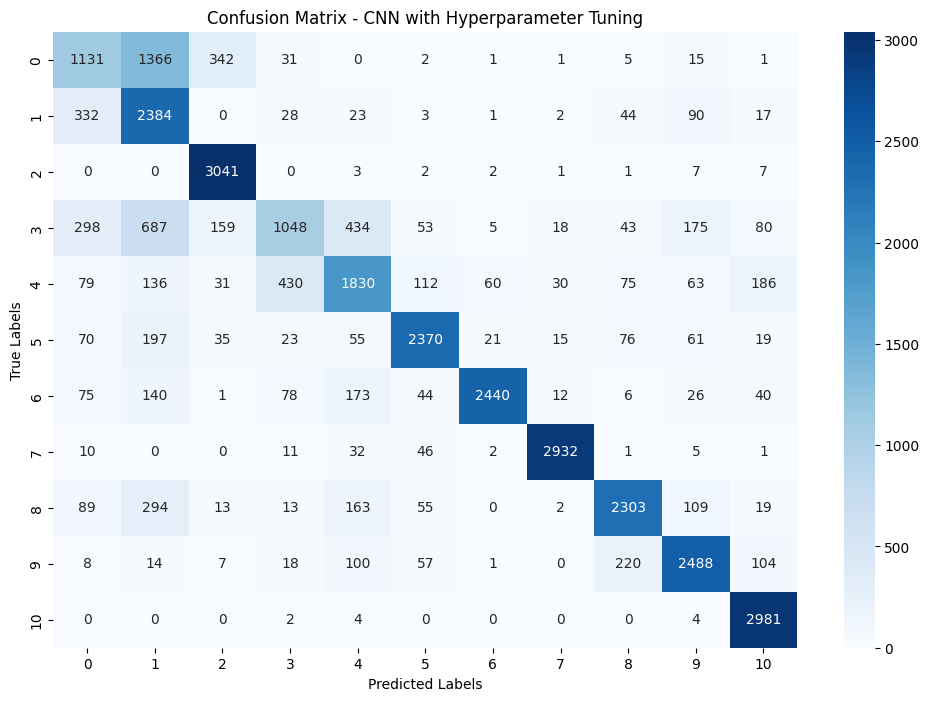

In [11]:
# Reshape the data for CNN input
X_train_cnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define a function to build the CNN model with more hyperparameters
def build_cnn_model(hp):
    model = Sequential()
    
    model.add(Conv1D(filters=hp.Int('filters_1', min_value=32, max_value=128, step=32), 
                     kernel_size=hp.Int('kernel_size_1', min_value=3, max_value=5, step=1), 
                     activation=hp.Choice('activation_1', ['relu', 'tanh']), 
                     input_shape=(X_train_cnn.shape[1], 1)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Conv1D(filters=hp.Int('filters_2', min_value=32, max_value=128, step=32), 
                     kernel_size=hp.Int('kernel_size_2', min_value=3, max_value=5, step=1), 
                     activation=hp.Choice('activation_2', ['relu', 'tanh'])))
    model.add(MaxPooling1D(pool_size=2))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(units=hp.Int('dense_units', min_value=32, max_value=128, step=32), 
                    activation=hp.Choice('activation_dense', ['relu', 'tanh'])))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout', 0.2, 0.5, step=0.1)))
    
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    # Tuning learning rate and optimizer
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])
    
    return model

# Initialize the Tuner for CNN using RandomSearch (with max_trials)
tuner_cnn = kt.RandomSearch(
    build_cnn_model,
    objective='val_accuracy',
    max_trials=50,  # Set to 50 trials
    executions_per_trial=1,  # You can increase this for more robust evaluation
    directory='my_dir', 
    project_name='cnn_random_search'
)

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Search for the best hyperparameters using 40 epochs
tuner_cnn.search(X_train_cnn, y_train, 
                 epochs=10,  # Use 15 epochs for hyperparameter tuning
                 validation_split=0.2, 
                 callbacks=[early_stopping])

# Get the best CNN model
best_cnn_model = tuner_cnn.get_best_models(num_models=1)[0]

# Train the best model with 80 epochs
best_cnn_model.fit(X_train_cnn, y_train, 
                   epochs=80,  # Use 80 epochs for final training
                   validation_split=0.2, 
                   callbacks=[early_stopping])

# Evaluate the best CNN model
y_pred_cnn = best_cnn_model.predict(X_test_cnn)
y_pred_classes_cnn = y_pred_cnn.argmax(axis=1)

# Print Accuracy and Classification Report for CNN
print("CNN Best Model Accuracy:", accuracy_score(y_test.argmax(axis=1), y_pred_classes_cnn))
print("CNN Best Model Classification Report:\n", classification_report(y_test.argmax(axis=1), y_pred_classes_cnn))

# Confusion Matrix for CNN
conf_matrix_cnn = confusion_matrix(y_test.argmax(axis=1), y_pred_classes_cnn)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_cnn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - CNN with Hyperparameter Tuning')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## 3. Recurrent Neural Network (RNN)

Reloading Tuner from Tuner/rnn_random_search/tuner0.json
Epoch 1/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - accuracy: 0.6818 - loss: 0.9036 - val_accuracy: 0.6342 - val_loss: 1.0937
Epoch 2/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.6897 - loss: 0.8734 - val_accuracy: 0.6902 - val_loss: 0.8569
Epoch 3/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.6935 - loss: 0.8642 - val_accuracy: 0.7102 - val_loss: 0.7971
Epoch 4/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.6966 - loss: 0.8458 - val_accuracy: 0.7061 - val_loss: 0.7922
Epoch 5/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 37s 11ms/step - accuracy: 0.6997 - loss: 0.8338 - val_accuracy: 0.7228 - val_loss: 0.7528
Epoch 6/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.7094 - loss: 0.8168 - val_accuracy: 0.7050 - val_loss: 0.8027
Epoch 7/80
3300/3300 ━━━━━━━━━━━━━━━━━━━━ 38s 11ms/step - accuracy: 0.7081 - loss: 0.8160 - val_accuracy: 0.6760 - val_loss: 0.8358
Epoch 8/80
3300/330

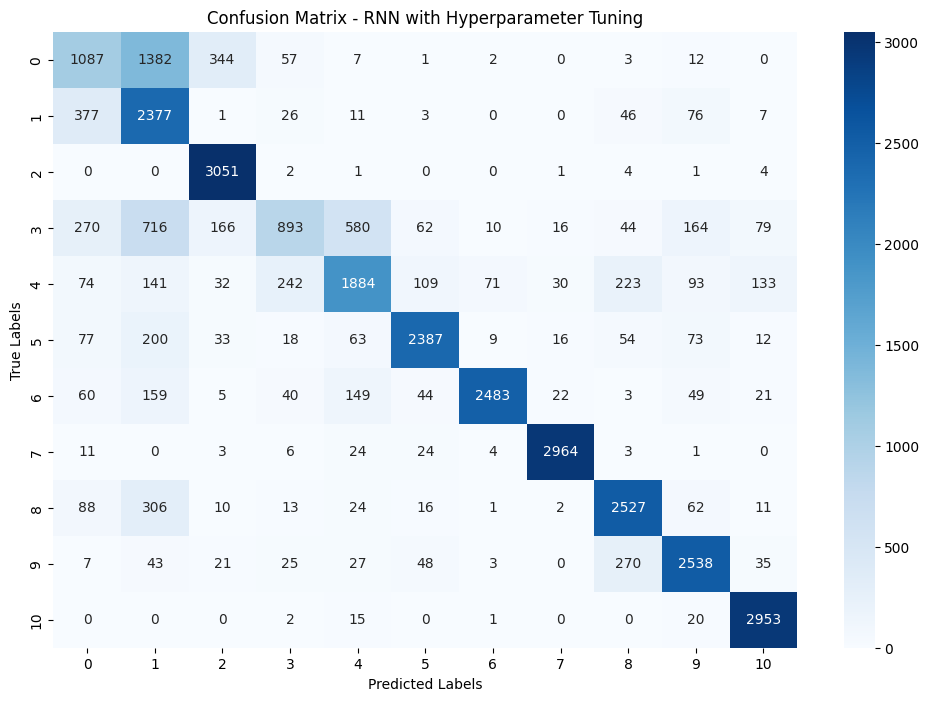

In [15]:
# Reshape the data for RNN input
X_train_rnn = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_rnn = X_test.values.reshape(X_test.shape[0], X_test.shape[1], 1)

# Define a function to build the RNN model with more hyperparameters
def build_rnn_model(hp):
    model = Sequential()

    # First LSTM Layer
    model.add(LSTM(units=hp.Int('units_1', min_value=64, max_value=256, step=64),
                   return_sequences=True, 
                   input_shape=(X_train_rnn.shape[1], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    # Second LSTM Layer
    model.add(LSTM(units=hp.Int('units_2', min_value=64, max_value=256, step=64), 
                   return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    # Third LSTM Layer
    model.add(LSTM(units=hp.Int('units_3', min_value=64, max_value=256, step=64), 
                   return_sequences=False))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_3', 0.2, 0.5, step=0.1)))

    # Fully Connected Layer
    model.add(Dense(units=hp.Int('dense_units', min_value=64, max_value=256, step=64), 
                    activation=hp.Choice('activation_dense', ['relu', 'tanh'])))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_dense', 0.2, 0.5, step=0.1)))

    # Output Layer
    model.add(Dense(y_categorical.shape[1], activation='softmax'))

    # Tuning learning rate and optimizer
    model.compile(optimizer=hp.Choice('optimizer', ['adam', 'sgd'], default='adam'),
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])

    return model

# Initialize the Tuner for RNN using RandomSearch
tuner_rnn = kt.RandomSearch(
    build_rnn_model, 
    objective='val_accuracy', 
    max_trials=40,  # Set to 60 trials for hyperparameter tuning
    executions_per_trial=1,  # You can increase this for more robust evaluation
    directory='Tuner', 
    project_name='rnn_random_search'
)

# Implement Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Search for the best hyperparameters using 40 epochs
tuner_rnn.search(X_train_rnn, y_train, 
                 epochs=5,  # Use 10 epochs for hyperparameter tuning
                 validation_split=0.2, 
                 callbacks=[early_stopping])

# Get the best RNN model
best_rnn_model = tuner_rnn.get_best_models(num_models=1)[0]

# Train the best model with 80 epochs
best_rnn_model.fit(X_train_rnn, y_train, 
                   epochs=80,  # Use 80 epochs for final training
                   validation_split=0.2, 
                   callbacks=[early_stopping])

# Evaluate the best RNN model
y_pred_rnn = best_rnn_model.predict(X_test_rnn)
y_pred_classes_rnn = y_pred_rnn.argmax(axis=1)

# Print Accuracy and Classification Report for RNN
print("RNN Best Model Accuracy:", accuracy_score(y_test.argmax(axis=1), y_pred_classes_rnn))
print("RNN Best Model Classification Report:\n", classification_report(y_test.argmax(axis=1), y_pred_classes_rnn))

# Confusion Matrix for RNN
conf_matrix_rnn = confusion_matrix(y_test.argmax(axis=1), y_pred_classes_rnn)
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix_rnn, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - RNN with Hyperparameter Tuning')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()